# **Import**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import json
import csv
import datetime as dt
import  math

import warnings

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

from numpy import mean
from numpy import std

from typing import List

In [2]:
import seaborn as sns
sns.set(style="ticks")
sns.set_color_codes("colorblind")
sns.set(style="darkgrid")

In [3]:
import warnings
warnings.filterwarnings('ignore')

# **Load of data, new columns, datatypes and period of time definiton**

In [4]:
soubor = pd.read_csv('final.csv', encoding='utf-8', low_memory=False)

Datatypes

In [5]:
soubor['TIMETABLE_ARRIVAL_TIME'] = pd.to_datetime(soubor['TIMETABLE_ARRIVAL_TIME']).dt.time

In [6]:
soubor['ORIGIN_TIMESTAMP'] = pd.to_datetime(soubor['ORIGIN_TIMESTAMP']).dt.time

In [7]:
soubor['START_TIME'] = pd.to_datetime(soubor['START_TIME']).dt.time

New column with time (hours&minutes) when the bus sent the location/was at the bus stop

In [8]:
for i, x in enumerate(soubor['ORIGIN_TIMESTAMP']):
    hour = x.hour
    minute = (math.floor(x.minute/10))*(1/6)
    soubor.loc[i,'HOUR'] = hour
    soubor.loc[i,'MINUTES'] = minute
    soubor.loc[i,'TIME'] = hour+minute

We want only rows where delay is higher than zero 

In [9]:
soubor = soubor[soubor['DELAY'] > 0]

Inside covid period / after covid period / week / weekend

In [10]:
inside_covid = soubor[(soubor['DATE'] <= '2020-05-17') & (~soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [11]:
len(inside_covid['UNICORN'].unique())

176

In [12]:
after_covid_week = soubor[(soubor['DATE'] >= '2020-05-18') & (~soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [13]:
len(after_covid_week['UNICORN'].unique())

238

In [14]:
after_covid_wknd = soubor[(soubor['DATE'] >= '2020-05-18') & (soubor['DAY_OF_WEEK'].isin(['Saturday','Sunday']))]

In [15]:
len(after_covid_wknd['UNICORN'].unique())

78

In [16]:
after_covid_full = soubor[soubor['DATE'] >= '2020-05-18']

In [17]:
len(after_covid_full['UNICORN'].unique())

316

In [18]:
t1 = dt.time(7,50,0)
t2 = dt.time(9,20,0)

In [19]:
full_week = after_covid_full[ (after_covid_full['ORIGIN_TIMESTAMP']>=t1) & (after_covid_full['ORIGIN_TIMESTAMP']<=t2) ]

# **Linear Regression**

In [20]:
data_for_regression = full_week[['DAY_OF_WEEK','DELAY','ORIGIN_TIMESTAMP','SEQUENCE']]

In [21]:
timestamp = pd.to_datetime(data_for_regression['ORIGIN_TIMESTAMP'].astype(str))
seconds = timestamp.dt.second
minutes = timestamp.dt.minute
hours = timestamp.dt.hour

timestamp_seconds = seconds + minutes * 60 + hours * 60 * 60
data_for_regression["TIMESTAMP_SECONDS"] = timestamp_seconds
data_for_regression.drop(columns=["ORIGIN_TIMESTAMP",], inplace=True)

In [22]:
data_for_regression

,DAY_OF_WEEK,DELAY,SEQUENCE,TIMESTAMP_SECONDS
2430,Tuesday,66.0,1,29591
2431,Tuesday,16.0,2,29656
2432,Tuesday,16.0,3,29891
2433,Tuesday,7.0,4,29942
2434,Tuesday,19.0,5,30009
...,...,...,...,...
8393,Saturday,121.0,9,33240
8394,Saturday,117.0,10,33302
8395,Saturday,88.0,11,33383
8396,Saturday,110.0,12,33473


source: *https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html*

**Categorical variables -> Dummy variables**

In [23]:
one_hot_dow = OneHotEncoder(drop="first", sparse=False)
one_hot_seq = OneHotEncoder(drop="first", sparse=False)

A_dummies_tmp = one_hot_dow.fit_transform(data_for_regression["DAY_OF_WEEK"].to_numpy().reshape(-1, 1))
A_dummies = pd.DataFrame(A_dummies_tmp, columns=one_hot_dow.get_feature_names()).dropna()

B_dummies_tmp = one_hot_seq.fit_transform(data_for_regression["SEQUENCE"].to_numpy().reshape(-1, 1))
B_dummies = pd.DataFrame(B_dummies_tmp, columns=one_hot_seq.get_feature_names()).dropna()

In [24]:
merged = pd.concat([
    data_for_regression.reset_index(drop=True),
    A_dummies.reset_index(drop=True),
    B_dummies.reset_index(drop=True),
],axis='columns')

In [25]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DAY_OF_WEEK        1766 non-null   object 
 1   DELAY              1766 non-null   float64
 2   SEQUENCE           1766 non-null   int64  
 3   TIMESTAMP_SECONDS  1766 non-null   int64  
 4   x0_Monday          1766 non-null   float64
 5   x0_Saturday        1766 non-null   float64
 6   x0_Sunday          1766 non-null   float64
 7   x0_Thursday        1766 non-null   float64
 8   x0_Tuesday         1766 non-null   float64
 9   x0_Wednesday       1766 non-null   float64
 10  x0_2               1766 non-null   float64
 11  x0_3               1766 non-null   float64
 12  x0_4               1766 non-null   float64
 13  x0_5               1766 non-null   float64
 14  x0_6               1766 non-null   float64
 15  x0_7               1766 non-null   float64
 16  x0_8               1766 

In [26]:
final = merged.drop(['DAY_OF_WEEK','SEQUENCE'],axis='columns')

#### We will predict Y from X

In [27]:
X = final.drop(['DELAY'],axis='columns')

Přidání konstanty (const = 1) z teoretického hlediska (=intercept).

In [28]:
X = sm.add_constant(X)

In [29]:
Y = final.DELAY

**OLS**

zdroj: *https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html?highlight=ols#statsmodels.regression.linear_model.OLS*

In [30]:
sm_model = sm.OLS(Y, X)
sm_result = sm_model.fit()

**Summary**

Diagnostické testy sloužící k posouzení přesnosti modelu

In [31]:
sm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  DELAY   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     42.99
Date:                Thu, 11 Jun 2020   Prob (F-statistic):          3.19e-141
Time:                        01:01:56   Log-Likelihood:                -10801.
No. Observations:                1766   AIC:                         2.165e+04
Df Residuals:                    1744   BIC:                         2.177e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.7873     56.036      0.085      0.932    -105.117     114.691
TIMESTAMP_SECONDS     0.0015      0.002      0.830      0.407      -0.002       0.005
x0_Monday            77.8023      8.822      8.819      0.000      60.500      95.105
x0_Saturday         -20.6715     13.145     -1.573      0.116     -46.454       5.111
x0_Sunday           -14.8864     13.991     -1.064      0.287     -42.327      12.554
x0_Thursday          39.4030      9.403      4.190      0.000      20.961      57.845
x0_Tuesday           43.4492      8.846      4.912      0.000      26.099      60.800
x0_Wednesday         63.6546      9.468      6.723      0.000      45.084      82.225
x0_2                 -3.5184     16.124     -0.218      0.827     -35.144      28.107
x0_3                 -1.3942     15.501     -0.090      0.928     -31.796      29.007
x0_4                 -3.0381     15.584     -0.195      0.845     -33.603      27.527
x0_5                 -5.9650     16.089     -0.371      0.711     -37.521      25.591
x0_6                  2.3632     15.448      0.153      0.878     -27.936      32.662
x0_7                 19.1162     15.148      1.262      0.207     -10.594      48.826
x0_8                 37.2361     15.169      2.455      0.014       7.484      66.988
x0_9                 40.4226     15.128      2.672      0.008      10.752      70.093
x0_10                36.0359     15.332      2.350      0.019       5.966      66.106
x0_11                55.4548     15.509      3.576      0.000      25.036      85.874
x0_12                88.7903     15.373      5.776      0.000      58.638     118.943
x0_13               154.6179     15.344     10.077      0.000     124.523     184.712
x0_14               181.2139     15.417     11.754      0.000     150.976     211.452
x0_15               215.7955     15.654     13.785      0.000     185.093     246.498
==============================================================================
Omnibus:                      239.634   Durbin-Watson:                   0.424
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              480.559
Skew:                           0.826   Prob(JB):                    4.45e-105
Kurtosis:                       4.950   Cond. No.                     6.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretace koeficientů**

Hodnota koeficientu TIMESTAMP_SECOND udává, že v případě zvýšení hodnoty o jednu sekundu se zpoždění zvýší o 0,0015 sekundy.

U dnů v týdnu se hodnoty koeficientu vztahují k pátku. Model nám tedy např. říká, že v pondělí můžeme počítat se zpožděním vyšším o 78 sekund oproti pátku.

Vliv jednotlivých zastávek na zpoždění je porovnáváno oproti první zastávce.

**R-squared**

Číslo popisuje, jak přesná bude predikce hodnot naší regresní rovnice. Čím blíže jsou data k regresní přímce, tím se hodnota R² zvyšuje, nejlepší skóre je 1. Všechny naše závislé proměnné X dohromady vysvětlují 34 % variace zpoždění (Y).

#### Model fit

In [32]:
model = LinearRegression()

In [33]:
model.fit(X.drop(columns="const"), Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
X.drop(columns="const").columns

Index(['TIMESTAMP_SECONDS', 'x0_Monday', 'x0_Saturday', 'x0_Sunday',
       'x0_Thursday', 'x0_Tuesday', 'x0_Wednesday', 'x0_2', 'x0_3', 'x0_4',
       'x0_5', 'x0_6', 'x0_7', 'x0_8', 'x0_9', 'x0_10', 'x0_11', 'x0_12',
       'x0_13', 'x0_14', 'x0_15'],
      dtype='object')

In [62]:
model.coef_

array([ 1.46687841e-03,  7.78023104e+01, -2.06714953e+01, -1.48864314e+01,
        3.94029860e+01,  4.34491713e+01,  6.36545799e+01, -3.51844295e+00,
       -1.39423288e+00, -3.03810664e+00, -5.96497739e+00,  2.36324696e+00,
        1.91161995e+01,  3.72361146e+01,  4.04225880e+01,  3.60359492e+01,
        5.54548495e+01,  8.87902574e+01,  1.54617943e+02,  1.81213895e+02,
        2.15795487e+02])

Koeficienty nám udávají, jakou váhu mají jednotlivé nezávislé proměnné.

#### Predikce

In [49]:
data_for_prediction = pd.DataFrame({
    "DAY_OF_WEEK": ["Tuesday"],
    "SEQUENCE": [13],
    "TIMESTAMP_SECONDS": [28216],
})

In [50]:
A_dummies_tmp = one_hot_dow.transform(data_for_prediction["DAY_OF_WEEK"].to_numpy().reshape(-1, 1))
A_dummies = pd.DataFrame(A_dummies_tmp, columns=one_hot_dow.get_feature_names()).dropna()

B_dummies_tmp = one_hot_seq.transform(data_for_prediction["SEQUENCE"].to_numpy().reshape(-1, 1))
B_dummies = pd.DataFrame(B_dummies_tmp, columns=one_hot_seq.get_feature_names()).dropna()

In [51]:
merged = pd.concat([
    data_for_prediction.reset_index(drop=True),
    A_dummies.reset_index(drop=True),
    B_dummies.reset_index(drop=True),
],axis='columns')

final = merged.drop(['DAY_OF_WEEK','SEQUENCE'],axis='columns')

In [52]:
final

,TIMESTAMP_SECONDS,x0_Monday,x0_Saturday,x0_Sunday,x0_Thursday,x0_Tuesday,x0_Wednesday,x0_2,x0_3,x0_4,...,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12,x0_13,x0_14,x0_15
0,28216,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [53]:
model.predict(final)

array([244.24386355])

**Check**

In [58]:
tuesday = data_for_regression[data_for_regression['DAY_OF_WEEK'] =='Tuesday' ]
real = tuesday[tuesday['SEQUENCE'] == 13]
real = real[real['TIMESTAMP_SECONDS'] == 28216]
real

,DAY_OF_WEEK,DELAY,SEQUENCE,TIMESTAMP_SECONDS
5517,Tuesday,198.0,13,28216


**Comparison of predicted values and real data**

In [41]:
predictions = model.predict(X.drop(columns = "const"))


df = pd.DataFrame(data = predictions)
df.columns = ['PREDICTED_DELAY']

In [42]:
df_predict = pd.concat([
    data_for_regression.reset_index(drop=True),
   df],axis = 'columns')
df_predict

,DAY_OF_WEEK,DELAY,SEQUENCE,TIMESTAMP_SECONDS,PREDICTED_DELAY
0,Tuesday,66.0,1,29591,91.642878
1,Tuesday,16.0,2,29656,88.219782
2,Tuesday,16.0,3,29891,90.688709
3,Tuesday,7.0,4,29942,89.119646
4,Tuesday,19.0,5,30009,86.291056
...,...,...,...,...,...
1761,Saturday,121.0,9,33240,73.297439
1762,Saturday,117.0,10,33302,69.001746
1763,Saturday,88.0,11,33383,88.539464
1764,Saturday,110.0,12,33473,122.006891


In [43]:
see = df_predict[['DELAY','PREDICTED_DELAY']]

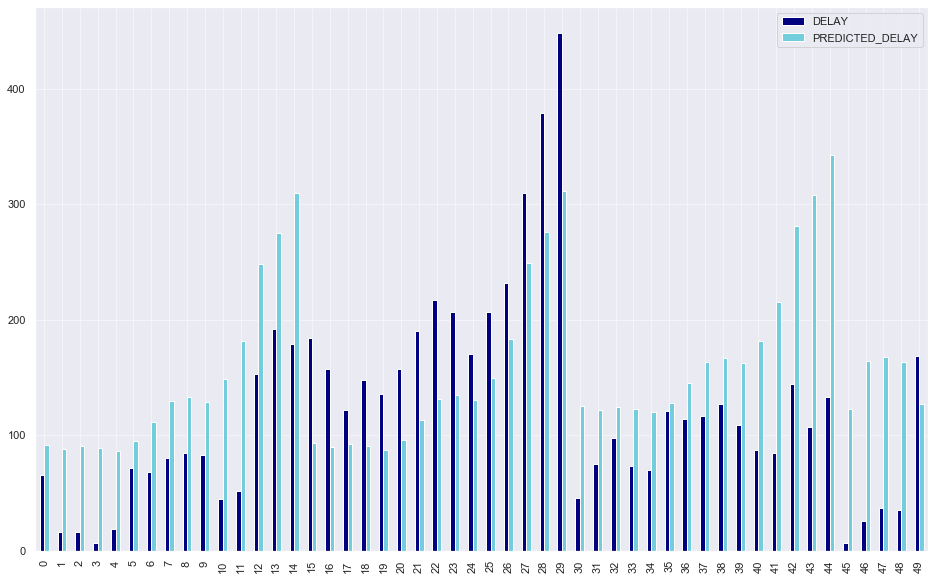

In [64]:
df1 = see.head(50)
df1.plot(kind='bar',figsize=(16,10), color=['#000080','#74CDDC'])
plt.grid(which='major', linestyle='-', linewidth='0.5', color='white')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()